<a href="https://colab.research.google.com/github/KwekuYamoah/Suicide-and-GDP-Case-Study/blob/main/Suicide_and_GDP_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Suicide and GDP Case Study

Kweku Andoh Yamoah and Jesse Jackson Zigi

[MIT License]((https://en.wikipedia.org/wiki/MIT_License)

## Introduction
This is the first in a series of notebooks that make up a case study in exploratory data analysis. In this notebook, we

1.   Read data Kaggle. [Suicide Rates Overview 1985 to 2016](https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016). The dataset is described as follows:
"*This compiled dataset pulled from four other datasets linked by time and place, and was built to find signals correlated to increased suicide rates among different cohorts globally, across the socio-economic spectrum.*"
2.   Clean the data, particulary dealing with special codes that indicate missing data.
1.   Validate the data by comparing the values in the dataset with values documented in the codebook specified on Kaggle.
2.   Use describe to compute summary statistics and  CDF to plot didtribution






## The Data

### General Informaation

*   **Original format**: csv
*   **Dataset shape**: 27820 x 12 (rows x columns)
*   19456 missing values for HDI

### Features in the dataset
#### <u>Categorical features</u>
**Country**: A total of 101 countries are included in this dataset. Most countries in Asia are not included and considering we have 195 countries in the world today, this is a quite biased data for worldwide analysis.<br>
**Year**: The dataset goes from 1985 to 2016<br>
**Sex**: Male/female differentiation<br>
**Age**: Age is divided in five age intervals.<br>
**Generation**: There are six generations included in this dataset. See 3.6 for details.
<br>
<blockquote>
    <p><font color="darkblue">This data's level of detail is defined by the combination of <b>Country+Year+Sex+Age</b>, which is a subsample of the population (e.g. Brazillian males of age between 15 and 25 in 1996). <br>For each of those we have corresponding numerical features.</font></p>
</blockquote>

#### <u>Numerical Features</u>
**Population size**: Number of people contained in each subsample
<br>**Number of Suicides**: Number of suicides in each subsample
<br>**Suicides per 100k people**: Number of suicides divided by the population size and multiplied by 100.000. This scales the number for better interpretation and allows you to make comparison between different subsamples.
<br>**GDP for year**: *Gross Domestic Product*, a measure of the market value for a country-year combination.
<br>**GDP per capita**: Obtained by dividing the GDP by the total population of the country for that year.
<br>**HDI for year** : *Human Development Index*, an index that measures life expectancy, income and education.
<br>

### Setup

If you are running this notebook in Colab, the following cell downloads the `empiricaldist` library.

If you are running in another environment, you will need to install it yourself.

In [61]:
# If we're running in Colab, set up the environment

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

The following cell loads the packages we need.  If everything works, there should be no error messages. Fingers crossed :)

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf
from empiricaldist import Cdf

The following cell defines a function I use to decorate the axes in plots.

In [63]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

## Reading the Data
The data we'll use is from Kaggle. I'll keep the original dataset as it is and create a new one to process the data throughout this analysis.

In [122]:
 #Load the data file

import os

if not os.path.exists('master.csv'):
    !wget https://raw.githubusercontent.com/KwekuYamoah/Suicide-and-GDP-Case-Study/main/master.csv


Now we can now read the file using Pandas. Pandas will read our information and store the results in a dataframe. We will view a few elements in the dataset to get a sense of the data

In [123]:
original_dataset = pd.read_csv("master.csv")
original_dataset.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


Let's see the number of countries in our dataset.

In [124]:
original_dataset['country'].unique(), len(original_dataset['country'].unique())

(array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
        'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
        'Barbados', 'Belarus', 'Belgium', 'Belize',
        'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cabo Verde',
        'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
        'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Ecuador',
        'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Georgia',
        'Germany', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary',
        'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
        'Kazakhstan', 'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Latvia',
        'Lithuania', 'Luxembourg', 'Macau', 'Maldives', 'Malta',
        'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Netherlands',
        'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay',
        'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar',
        'Republic of Korea

Our data came in a clear format. Missing values are already recoded with NaN. The next step is to create a copy of the dataset and use it throughout our analysis. We want to maintain the structure of the original dataset. Also, we will rename a few columns and remove HDI (too many missing values) to make interpretation and coding easier. Finally we drop some columns which we won't use in our analysis as well.

In [125]:
#Creating a dataset copy
df = original_dataset.copy()

#Renaming a few columns to make interpretation and coding easier
df.rename(columns = {
    'suicides_no':'total_suicides',
    'suicides/100k pop':'suicides_per_100k',
    ' gdp_for_year ($) ':'gdp_for_year',
    'gdp_per_capita ($)':'gdp_per_capita',
    'HDI for year': 'HDI_for_year'
}, inplace=True)

#Dropping country-year due to redundancy
df = df.drop('country-year', axis=1)

#Dropping HDI_for_year due to the number of missing value
#HDI_for_year won't be used in our analysis
df = df.drop(columns='HDI_for_year')


#Values for gdp per year are strings. Fixing to a float
df.gdp_for_year = df.gdp_for_year.apply(lambda x: float(''.join(x.split(','))))

Now let's see how our data set is looking

## EDA

Years is our time index. We will explore other features together with year to look for trends.
The years range from 1985 to 2015. Let's take a look at both ends of our dataset.

In [126]:
#Creating an aggregate dictionary to get the essential elements of the dataset
agg_dict = {'country':'nunique', 'age':'nunique',
            'population':'sum',
            'total_suicides':'sum',
            'suicides_per_100k':'mean'}
#Query to display  the dataset
dataset = df.query('year >= 1985')

#Grouping by year using the features of agg_dict
dataset = dataset[['year', 'country',
                       'age', 'population',
                       'total_suicides',
                       'suicides_per_100k']].groupby('year').agg(agg_dict)
#Rename columns
'''dataset.rename(columns={'country':'Distinct Countries', 'age':'Age groups',
                          'population':'Sum of Population', 'total_suicides':'Sum of Suicides',
                          'suicides_per_100k':'Avg Suicides Ratio per 100k'}, inplace=True)'''
#Calculating sucide ratio as Sum of Suicides/Sum of Population
dataset['calc_suicide_ratio'] = 1e5 * dataset['total_suicides'] / dataset['population']

dataset

,country,age,population,total_suicides,suicides_per_100k,calc_suicide_ratio
year,,,,,,
1985,48,6,1008600086,116063,11.826198,11.507336
1986,48,6,1029909613,120670,11.423333,11.716562
1987,54,6,1095029726,126842,11.644213,11.583430
1988,49,6,1054094424,121026,12.709405,11.481514
1989,52,6,1225514347,160244,12.879071,13.075653
1990,64,6,1466620100,193361,12.862956,13.184123
1991,64,6,1489988384,198020,13.438880,13.290036
1992,65,6,1569539447,211473,13.498564,13.473570
1993,65,6,1530416654,221565,13.833705,14.477430


*   We can see that the data from 2016 has 16 countires and is missing an age group. We decide no to use this year since it affects our trend analysis.
*   Also the number of countries vary in the data each year.



In [127]:
#Dropping the year "2016"
dataset = dataset.query('year !=2016')
dataset

,country,age,population,total_suicides,suicides_per_100k,calc_suicide_ratio
year,,,,,,
1985,48,6,1008600086,116063,11.826198,11.507336
1986,48,6,1029909613,120670,11.423333,11.716562
1987,54,6,1095029726,126842,11.644213,11.583430
1988,49,6,1054094424,121026,12.709405,11.481514
1989,52,6,1225514347,160244,12.879071,13.075653
1990,64,6,1466620100,193361,12.862956,13.184123
1991,64,6,1489988384,198020,13.438880,13.290036
1992,65,6,1569539447,211473,13.498564,13.473570
1993,65,6,1530416654,221565,13.833705,14.477430


In [164]:
# Too many missing values from 2016 therefore we are removing all 2016 records 
# This earlier version of the dataframe is used for further data visualizations 
df = df[df['year']!='2016']

Currently we have our cumulative distribution for year, population	total_suicides	suicides_per_100k	calc_suicide_ratio. Now let's look at the mean and standard deviation for total_sucides, suicide_per_100K, calc_suicide_ratio




Calculating this we can use the mean and std functions from numpy and pandas. But we use the one from Pandas

In [165]:
# Mean and standard deviation for total sucides from 1985-2015
mean_tol = dataset['total_suicides'].mean()
std_tol = dataset['total_suicides'].std()
print("Mean and standard deviation of total suicides:\n")
(mean_tol,std_tol)


Mean and standard deviation of total suicides:



(217187.64516129033, 42969.61275331547)

In [166]:
# Mean and standard deviation for suicide_per_100K
mean_100_k = dataset['suicides_per_100k'].mean()
std_100_k = dataset['suicides_per_100k'].std()
print("Mean and standard deviation for suicide per 100K people:\n")
(mean_100_k,std_100_k)

Mean and standard deviation for suicide per 100K people:



(12.796811790816218, 1.3987540436576158)

In [167]:
#Repeating for suicide ratio
mean_ratio= dataset['calc_suicide_ratio'].mean()
std_ratio = dataset['calc_suicide_ratio'].std()
print("Mean and standard deviation for Sucide Ratio by the years:\n")
(mean_ratio,std_ratio)

Mean and standard deviation for Sucide Ratio by the years:



(13.12022680020077, 1.2124725358950612)

We then plot the mean and standard deviation of total suicides and suicides per 100k. 

We see that the number of suicides was steadily rising between 1985 and 1995. It levelled off between 1995 and 2010 and then sharply fell off.

The suicide per 100k followed the rising trend between 1985 and 1995 and then abruptly declined. However since the 2010s, it has started to rise rather drastically.

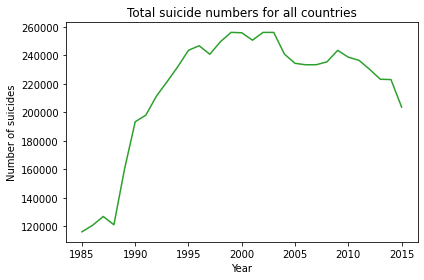

In [168]:
total_suicides = dataset['total_suicides'] 
total_suicides.plot(color="C2", label='Total Suicides')
decorate(xlabel='Year', 
         ylabel='Number of suicides',
         title='Total suicide numbers for all countries')



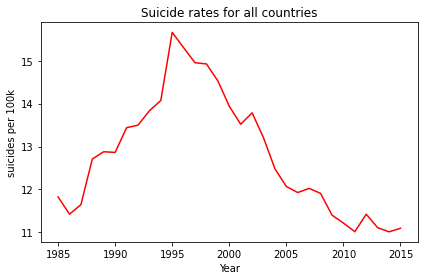

In [169]:
per_100K = dataset['suicides_per_100k'] 
per_100K.plot(color="red", label='Total Suicides')
decorate(xlabel='Year', 
         ylabel='suicides per 100k',
         title='Suicide rates for all countries')

In [170]:
# per_100K = dataset['calc_suicide_ratio'] 
# per_100K.plot(color="C4", label='Total Suicides')
# decorate(xlabel='Year', 
#          ylabel='suicide ratio',
#          title='Suicide Ratio for all countries')

## Exploration of Suicide Rates

Let's start our exploration of interest. We will first explore `suicides_per_100k`

To see how the responses have changed over time, we'll inspect them at the beginning and end of the observation period.

First I'll select the column.

In [171]:
suicide_per_100k = df['suicides_per_100k']

Then compute a Boolean Series that's True for responses from 1985.

In [172]:
year85 = (df['year'] == 1985)

Now we can select suicide rates from 1985

In [173]:
suicide85_per_100k = suicide_per_100k[year85]

We'll use the function values to plot the values in the series and their frequencies.

In [174]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts().sort_index()

Here are the responses from 1985.

In [175]:
values(suicide85_per_100k)

0.00      129
0.03        1
0.06        1
0.08        2
0.13        1
         ... 
101.52      1
120.49      1
125.22      1
131.17      1
144.65      1
Name: suicides_per_100k, Length: 408, dtype: int64

And here are the responses from 2015.

In [176]:
year15 = (df['year'] == 2015)
suicide15_per_100k = suicide_per_100k[year15]
values(suicide15_per_100k)

suicide15_per_100k.describe(), suicide85_per_100k.describe()


(count    744.000000
 mean      11.094073
 std       15.144091
 min        0.000000
 25%        1.307500
 50%        6.065000
 75%       14.232500
 max      140.740000
 Name: suicides_per_100k, dtype: float64, count    576.000000
 mean      11.826198
 std       19.216259
 min        0.000000
 25%        0.280000
 50%        4.740000
 75%       14.782500
 max      144.650000
 Name: suicides_per_100k, dtype: float64)

## CDFs

To visualize these distributions, we'll use the **Cumulative Distribution Function** (CDF), which is similar to a histogram.  The CDF ***shows the cumulative probability distribution of our suicide records***.

I use the `Cdf` class from `empiricaldist` to compute them.

Here's the distribution from 1985. But first let's see the probability distribution of the responses



In [177]:
cdf85 =  Cdf.from_seq(suicide85_per_100k)
cdf85


,probs
0.00,0.223958
0.03,0.225694
0.06,0.227431
0.08,0.230903
0.13,0.232639
...,...
101.52,0.993056
120.49,0.994792
125.22,0.996528
131.17,0.998264


Now we plot this distribution from 1985:

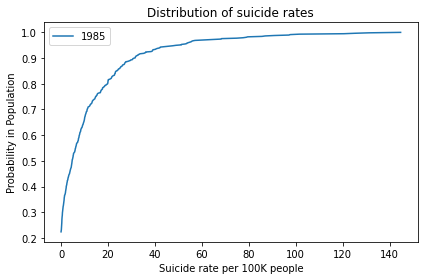

In [178]:
cdf85.plot(label='1985', color='C0', alpha = 1 )

decorate(xlabel='Suicide rate per 100K people',
         ylabel='Probability in Population',
         title='Distribution of suicide rates')

plt.legend();

Here's the distribution from 2015:

,probs
0.00,0.107527
0.04,0.108871
0.10,0.111559
0.11,0.112903
0.14,0.114247
...,...
82.62,0.994624
84.09,0.995968
91.42,0.997312
99.45,0.998656


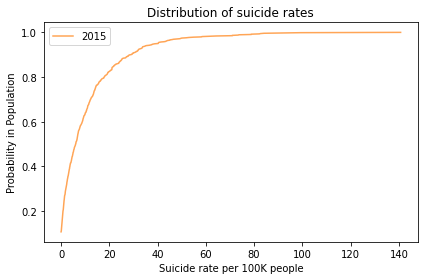

In [179]:
cdf15 =  Cdf.from_seq(suicide15_per_100k)
cdf15.plot(label='2015', color='C1', alpha = 0.7 )

decorate(xlabel='Suicide rate per 100K people',
         ylabel='Probability in Population',
         title='Distribution of suicide rates')

plt.legend();
cdf15

In both cases, we observe that the probaility of observing a suicide rate of below about 20 per 100K people is 80%. Rates above that can be considered unusual but not unlikely.

To make it easier to compare the distributions, we'll plot them side by side.

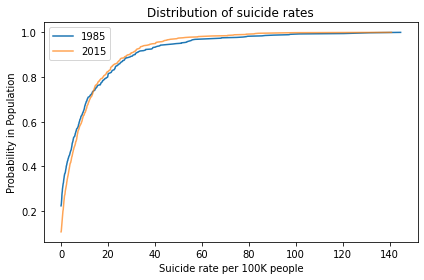

In [180]:
cdf85.plot(label='1985', color='C0', alpha = 1 )
cdf15.plot(label='2015', color='C1', alpha = 0.7 )

decorate(xlabel='Suicide rate per 100K people',
         ylabel='Probability in Population',
         title='Distribution of suicide rates')

plt.legend();

Now we can see the changes in the distribution more clearly. It looks like the rates has not really changed much in the past 30 years.

 To summarize these changes, we can compare the mean and standard deviation of suicide rates in 1985 and 2015.

The mean of the responses measures the balance of lives lost in the population through suicide. If the mean increases over time, that might indicate a high number of lives lost through suicide.

The standard deviation measures the dispersion of rates in the population; if it increases over time, that might indicate an increase in the spread of rates as well.

Here's the mean and standard deviation from 1985 and 2015:

In [181]:
mean85 = suicide85_per_100k.mean()
std85 = suicide85_per_100k.std()
(mean85,std85)

(11.826197916666661, 19.216258721669814)

In [182]:
mean15 = suicide15_per_100k.mean()
std15 = suicide15_per_100k.std()
(mean15,std15)

(11.094072580645154, 15.144090904167951)

We can see that the mean has decreased a little over time. Which means that the reates are slowly reducing. Also, the standard deviartion has greatly reduce, which means the rates are not really spread out in the population. It could be that there are less groups of people committing suicider by, for example, age group or gender

## Exploration of GDP

Our focus is on suicide rates and GDP. Now we focus on doing a similar analysis for GDP. We use GDP per capita which is the avaerage level of national income per person.

Let's get GDP per capita for 1985 and plot the CDF for it:

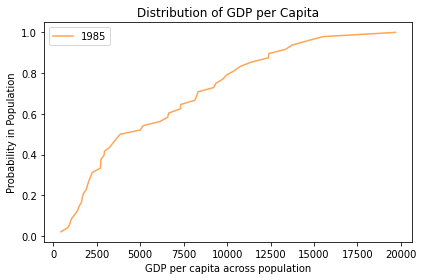

In [183]:
gdp_per_capita = df['gdp_per_capita']
year85 = (df['year'] == 1985)
gdp_per_capita85 = gdp_per_capita[year85]
cdf85 =  Cdf.from_seq(gdp_per_capita85)
cdf85.plot(label='1985', color='C1', alpha = 0.7 )

decorate(xlabel='GDP per capita across population',
         ylabel='Probability in Population',
         title='Distribution of GDP per Capita')

plt.legend();

Let's repeat for 2015:


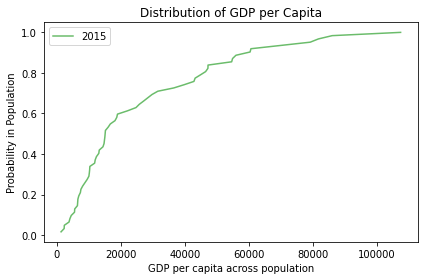

In [184]:

year15 = (df['year'] == 2015)
gdp_per_capita15 = gdp_per_capita[year15]
cdf15 =  Cdf.from_seq(gdp_per_capita15)
cdf15.plot(label='2015', color='C2', alpha = 0.7 )

decorate(xlabel='GDP per capita across population',
         ylabel='Probability in Population',
         title='Distribution of GDP per Capita')

plt.legend();

Now we plot them side by side to see the trend

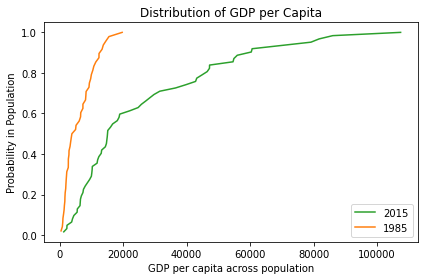

In [185]:
cdf15.plot(label='2015', color='C2', alpha = 1.0 )
cdf85.plot(label='1985', color='C1', alpha = 1.0 )

decorate(xlabel='GDP per capita across population',
         ylabel='Probability in Population',
         title='Distribution of GDP per Capita')

plt.legend();

The graph shows the wealth disparity between 1985 and 2015. In 1985, the disparity between GDP per capita of the recorded nations was much smaller than in 2015

Here's the mean and standard deviation from 1985 and 2015 for GDP per capita:

In [186]:
mean85 = gdp_per_capita85.mean()
std85 = gdp_per_capita85.std()
(mean85,std85)

(6091.229166666667, 4732.247733187785)

In [187]:
mean15 = gdp_per_capita15.mean()
std15 = gdp_per_capita15.std()
(mean15,std15)

(26231.1935483871, 24035.98965336343)

Aided by the mean and standard deviation, we can confirm GDP per capita has increased on through out the population. However, the disparity too as indicated by the standard deviation increased by a factor of almost 6.This paints a picture of increased inequality in the world.

## Time series

At this point we have looked at the endpoints, 1985 and 2015, but we don't know what happened in between. Let us see the list of countries we have after removing HDI, 2016 and missing data




In [188]:
df['country'].unique()

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cabo Verde',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Ecuador',
       'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary',
       'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Kazakhstan', 'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Latvia',
       'Lithuania', 'Luxembourg', 'Macau', 'Maldives', 'Malta',
       'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay',
       'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar',
       'Republic of Korea', 'Romania', '

To see how the distribution changes over time, we can group by year and compute the mean of `suicides_per_100k` and `gdp_per_capita` during each year.

First I'll use `groupby` to group the respondents by year.

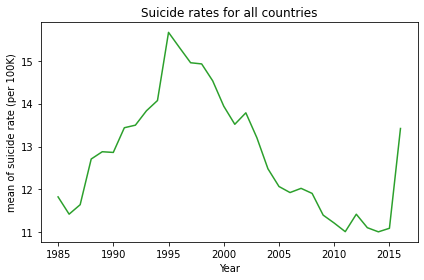

In [189]:
fullDF = df
# Grouping by year
fullDF_by_year = fullDF.groupby('year')
suicide_by_year = fullDF_by_year['suicides_per_100k']
suicide_mean = suicide_by_year.mean()

# Function to decorate plot
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

  
suicide_mean.plot(color='C2', label='suicide numbers')
decorate(xlabel='Year', 
         ylabel='mean of suicide rate (per 100K)',
         title='Suicide rates for all countries')




The results is a series that contains the sum of suicide rate per 100k in the whole population recorded for each year. We can see the mean peaked in 1995. 


Let's look at the mean series for gdp_per_capita

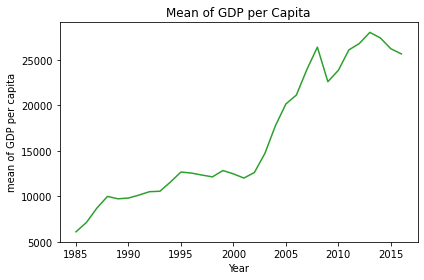

In [190]:
fullDF_by_year = fullDF.groupby('year')
gdp_by_year = fullDF_by_year['gdp_per_capita']
gdp_mean = gdp_by_year.mean()

gdp_mean.plot(color='C2', label='gdp per capita')
decorate(xlabel='Year', 
         ylabel='mean of GDP per capita',
         title='Mean of GDP per Capita')

We observe that GDP per capita was seeing a steady rise until a sharp decrease around 2008. The sharp dip is most likely a result of the 2008 economic recession.

## Top 10 Countries
Now lets group the data by countries

The country_year_range function defined below applies a filter for year range and then groups the data by country. It performs the proper grouping calculation like I commented before.
It also adds a Years Present column to count the number of years certain country was present in the data.
Following the coding rule: "If you used it three times, make it a function"

In [191]:
def country_year_range(data, start=None, end=None):
    if (start == None) and (end == None):
        data = data
    
    elif end == None:
        data = data.query('year >= @start')
        
    elif start == None:
        data = data.query('year <= @end')
        
    else:
        year_range = np.arange(start, end+1)
        data = data.query('year in @year_range')
    
    # Aggregating each column properly.
    agg_dict = {'country':'count', 'year':'nunique',
                'total_suicides':'sum', 'population':'sum',}
    df = data[['country', 'year',
               'total_suicides', 'population']].groupby('country').aggregate(agg_dict)

    # Creating our usual feature
    df['Avg. Suicide per 100k'] = df['total_suicides'] * 1e5 / (df['population'])

    df = df.drop(['country', 'total_suicides', 'population'], axis=1)
    df.rename(columns={'year':'Years_Present'}, inplace = True)
    
    return df

In [192]:
# Country data for the whole dataset
country_data = country_year_range(df)

# Country data after (and including) 2011
rec_country_data = country_year_range(df, start=2011)

country_data

,Years_Present,Avg. Suicide per 100k
country,,
Albania,22,3.160827
Antigua and Barbuda,27,0.552700
Argentina,31,7.936309
Armenia,25,2.462889
Aruba,14,8.017928
...,...,...
United Arab Emirates,6,1.704003
United Kingdom,31,7.867928
United States,31,12.838459


The graph plotted below shows a 2 x 2 grid with the highest/lowest suicide rates between countries for all years and for the LAST FIVE YEARS of our dataset.

I have applied filters to include only countries with at least 20 years of data for all years and at least 4 years of data for the last 5 years. (these numbers were chosen arbitrarly to reduce noise from countries with few data points).

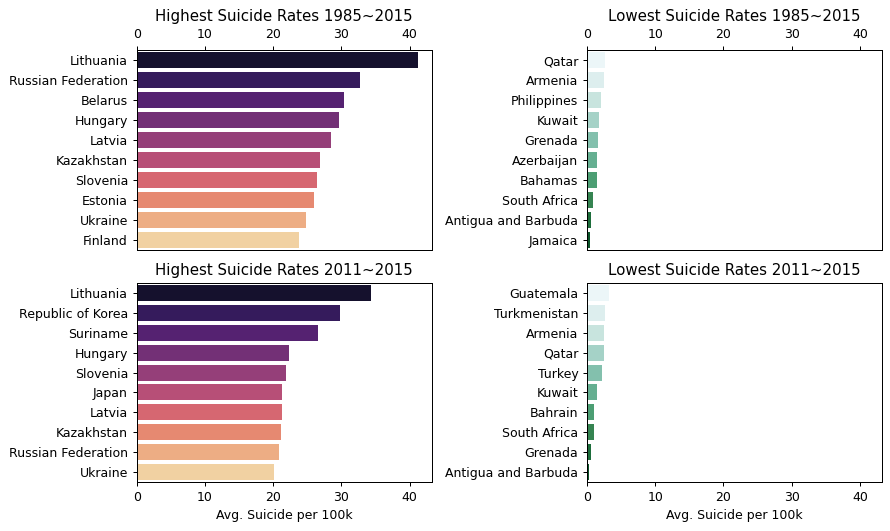

In [193]:
frequent_countries = country_data.sort_values('Avg. Suicide per 100k', ascending=False)
frequent_countries = frequent_countries.query("Years_Present >= 15")

r_frequent_countries = rec_country_data.sort_values('Avg. Suicide per 100k', ascending=False)
r_frequent_countries = r_frequent_countries.query("Years_Present >= 4")


# Defining the 2 x 2 graph grid
fig, (row1, row2) = plt.subplots(2,2, figsize=(10,6), dpi=90, sharex=True)


# FIRST ROW
# Left Graph
row1[0].set_title('Highest Suicide Rates 1985~2015')
sns.barplot(data=frequent_countries[:10], x='Avg. Suicide per 100k',
            y=frequent_countries[:10].index, ax=row1[0], palette='magma')
row1[0].xaxis.label.set_visible(False)
row1[0].yaxis.label.set_visible(False)
row1[0].xaxis.set_ticks_position('top')

# Right Graph
row1[1].set_title('Lowest Suicide Rates 1985~2015')
sns.barplot(data=frequent_countries[-10:], x='Avg. Suicide per 100k',
            y=frequent_countries[-10:].index, ax=row1[1], palette='BuGn')
row1[1].xaxis.label.set_visible(False)
row1[1].yaxis.label.set_visible(False)
row1[1].xaxis.set_ticks_position('top')


# SECOND ROW
# Left Graph
row2[0].set_title('Highest Suicide Rates 2011~2015')
sns.barplot(data=r_frequent_countries[:10], x='Avg. Suicide per 100k',
            y=r_frequent_countries[:10].index, ax=row2[0], palette='magma')
row2[0].yaxis.label.set_visible(False)

# Right Graph
row2[1].set_title('Lowest Suicide Rates 2011~2015')
sns.barplot(data=r_frequent_countries[-10:], x='Avg. Suicide per 100k',
            y=r_frequent_countries[-10:].index, ax=row2[1], palette='BuGn')
row2[1].yaxis.label.set_visible(False)

plt.tight_layout();

## The 1995 Increase in Suicide Rates

To analyse this phenomenon I will gather data from 1995 and from a previous year. I arbitrarly chose to compare it to 1989 by looking at the graph from 
the prevuous section

To get the table below

1.   Grouped the data by country and year, summing population and suicides and then calculating the ratio
2.   Filtered the data for 1989 and 1995 only, and then created a pivot table with those years as different columns
1.   Ordered the table by the changes in number of suicides descending.





In [194]:
country_year_gb = df.groupby(['country', 'year'],
                                  as_index=False).sum()[['country', 'year',
                                                         'total_suicides', 'population']]

country_year_gb['Suicides_per_100k'] = 1e5 * country_year_gb['total_suicides'] / country_year_gb['population']

nnfive = country_year_gb.query("year in [1989, 1995]").pivot_table(index='country',
                                                                   columns='year',
                                                                   values=['total_suicides',
                                                                           'Suicides_per_100k'],
                                                                   aggfunc='sum')

nnfive['Changes in Number of Suicides'] = (nnfive.iloc[:,3] - nnfive.iloc[:,2])

nnfive.sort_values('Changes in Number of Suicides', ascending=False)[:6]

Suicides_per_100k  ... Changes in Number of Suicides
year                            1989  ...                              
country                               ...                              
Russian Federation         27.997590  ...                       22627.0
Ukraine                    22.794415  ...                        3654.0
Brazil                      3.471252  ...                        2073.0
Republic of Korea           7.717346  ...                        1818.0
United States              13.167630  ...                        1054.0
Mexico                      2.613546  ...                        1012.0

[6 rows x 5 columns]

The numbers on Russia are impressive. Looks like Russia single-handedly increased the World's suicide average.
Lets see how the same graphs from 3.1 looks without Russia.

In [195]:
# Creating a filtered dataset by removing Russia and calculation our Ratio
without_ru = df.query("country != 'Russian Federation'") \
                .groupby('year', as_index=False).sum()

without_ru['Suicides per 100k'] = 1e5 * without_ru['total_suicides']/without_ru['population']

In [196]:
agg_dict = {'country':'nunique', 'population':'sum', 'total_suicides':'sum'}
yearly_data = df[['year', 'country', 
                       'population',
                       'total_suicides']].groupby('year', as_index=False).agg(agg_dict)

yearly_data.rename(columns={'population':'Population',
                            'total_suicides':'Total Suicides'}, inplace=True)
yearly_data['Suicides by 100k people'] = 100000 * yearly_data['Total Suicides'] / ( yearly_data['Population'] )


For the next steps: 


We defined both Y-axis so that both measures have the same relative change and can be better interpreted. In other words, the vertical distance between the dashed line and the solid line mean the same thing in terms of percentage change for both plots.
That way we can see that suicide numbers had a larger increase when adding Russia compared to the increase in population, specially between 1995 and 2005.

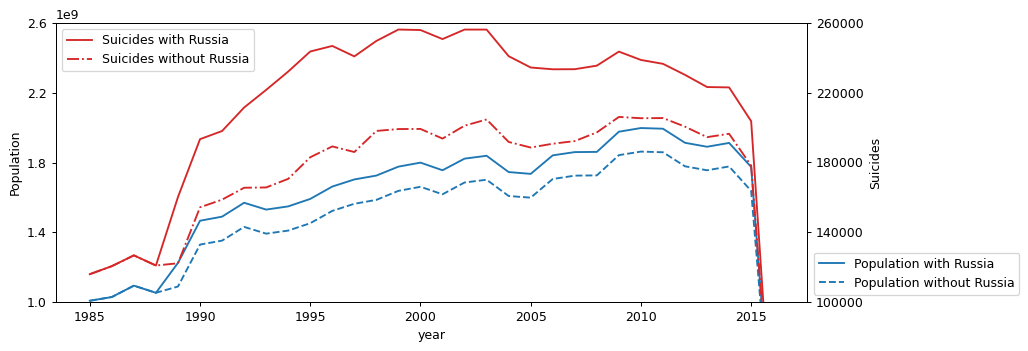

In [197]:
## Primary Axis - Population
# Plotting
fig, ax1 = plt.subplots(1,1,figsize=(10,4), dpi=90, sharey=False)

yearly_data.plot(x='year', y='Population', ax=ax1,
                 label='Population with Russia', c='C0', ls='-')

without_ru.plot(x='year', y='population', ax=ax1,
                    label='Population without Russia', c='C0', ls='--')

# Formatting
ax1.set_ylim(1e9, 2.6e9)
ax1.set_yticks([1e9, 1.4e9, 1.8e9, 2.2e9, 2.6e9])
ax1.grid(False)
ax1.set_ylabel('Population')

## Secondary Axis - Suicides
# Plotting
ax1b = ax1.twinx()
yearly_data.plot(x='year', y='Total Suicides', ax=ax1b, c='C3',
                 ls='-', label='Suicides with Russia')
without_ru.plot(x='year', y='total_suicides', ax=ax1b, c='C3',
                    ls='-.', label='Suicides without Russia')
# Formatting
ax1b.set_ylim(1e5, 2.6e5)
ax1b.grid(False)
ax1b.set_ylabel('Suicides')
ax1b.set_yticks([1e5, 1.4e5, 1.8e5, 2.2e5, 2.6e5])

plt.tight_layout()
ax1.legend(bbox_to_anchor=(1, 0.2));

In [198]:
# Defining this because I will use it to make the plots somewhat standard

def standard_plot(title=None, x=None, y=None):
    
    fig, ax = plt.subplots(figsize=(12,4), dpi=80)
    
    ax.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.label.set_fontsize(12)
    ax.yaxis.label.set_fontsize(14)
   
    if title != None:
        ax.set_title(title)
        ax.title.set_fontsize(15)
        
    if x != None:
        ax.set_xlabel(x)
        
    if y != None:
        ax.set_ylabel(y)
          
    return fig, ax

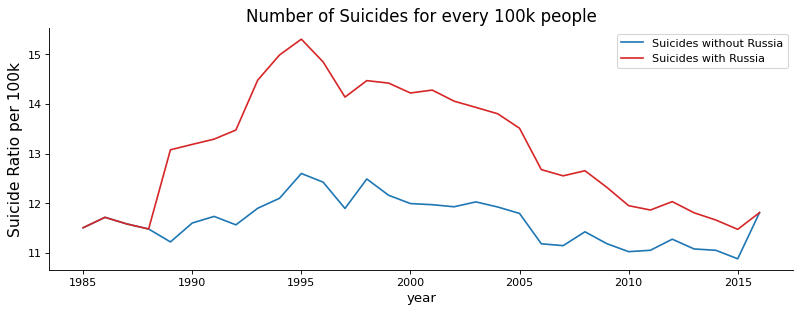

In [199]:
fig, ax = standard_plot('Number of Suicides for every 100k people',
                        'Year', 'Suicide Ratio per 100k')

without_ru.plot(kind='line', x='year', y='Suicides per 100k',
                    ax=ax, label='Suicides without Russia', grid=False)

yearly_data.plot(kind='line', x='year', y='Suicides by 100k people',
                 ax=ax, label='Suicides with Russia', c='C3', grid=False);

Apparently Russia has a serious problem on this delicate subject. I come from Ghana and I didn't have a clue on this.
Some researchers attribute this to alcooholism [(link)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1642767/). I will not dive into this as I was totally unaware of this problem up until this analysis

## Cross Tabulations

In this section, explore the possible relationships between gender, age group and suicide rate. Specifically, we'll compute the number of respondents in each category for each year, and plot changes over time.

Pandas provides a function called crosstab that computes a cross tabulation.

It takes two Series as arguments and returns a DataFrame.

In [200]:
#cross tabulation of year and gender with mean suicide rate as values
year = fullDF['year']
gender = fullDF['sex']
suicide_rate = fullDF['suicides_per_100k']
# fullDF['country'].unique().size

yearxgender = pd.crosstab( year, gender, suicide_rate, aggfunc=np.mean)

yearxgender.dropna(inplace=True)
yearxgender.head()


sex,female,male
year,,
1985,5.776910,17.875486
1986,5.812674,17.033993
1987,5.732130,17.556296
1988,6.323401,19.095408
1989,6.176827,19.581314


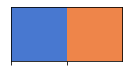

In [201]:
palette = sns.color_palette('muted', 2)
sns.palplot(palette)
columns=['female','male']
color_map = dict(zip(columns, palette))

In [202]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    """Use LOWESS to compute a smooth line.
    
    series: pd.Series
    
    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index) 

def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.
    
    series: pd.Series
    color: string or tuple
    """
    series.plot(linewidth=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)

def plot_columns_lowess(table, columns, colors):
    """Plot the columns in a DataFrame.
    
    table: DataFrame with a cross tabulation
    columns: list of column names, in the desired order
    colors: mapping from column names to colors
    """
    for col in columns:
        series = table[col]
        plot_series_lowess(series, colors[col])

def anchor_legend(x, y):
    """Place the upper left corner of the legend box.
    
    x: x coordinate
    y: y coordinate
    """
    plt.legend(bbox_to_anchor=(x, y), loc='upper left', ncol=1)

Plotting the times eries of suicide rates by gender, we observe that men are almost 4 times as likely to commit suicide as compared to women

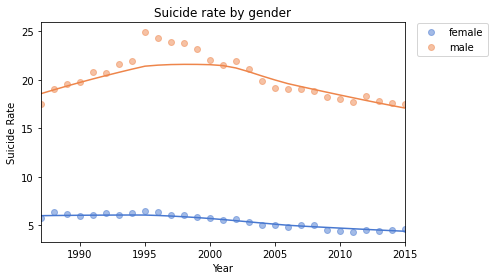

In [203]:
# Male vs Female suicide rate (per 100k)

plot_columns_lowess(yearxgender, columns, color_map)
decorate(xlabel='Year',
         ylabel='Suicide Rate',
         title='Suicide rate by gender',
         xlim=[1987, 2015])
anchor_legend(1.02, 1.02)

Plotting the time series of suicide rates by age group, we observe that people older than 75 are almost twice as likely to commit suicide as compared as those between 25 and 74 cumulatively. People under the age of 15 are the least likely to commit suicide

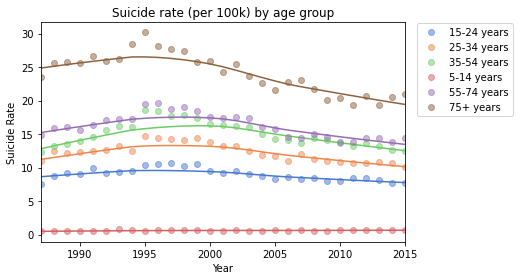

In [204]:
#cross tabulation of year and age with mean suicide rate as values
age = fullDF['age']

yearxage = pd.crosstab( year, age, suicide_rate, aggfunc=np.mean)

yearxage.dropna(inplace=True)
palette1 = sns.color_palette('muted', 6)
columns1=['15-24 years','25-34 years', '35-54 years', '5-14 years', '55-74 years', '75+ years']
color_map2 = dict(zip(columns1, palette1))


# Age group suicide rate (per 100k)

plot_columns_lowess(yearxage, columns1, color_map2)
decorate(xlabel='Year',
         ylabel='Suicide Rate',
         title='Suicide rate (per 100k) by age group',
         xlim=[1987, 2015])
anchor_legend(1.02, 1.02)

Plotting the time series of male suicide rates by age group, we see that it follows the trends observed in the suicide rates by age.

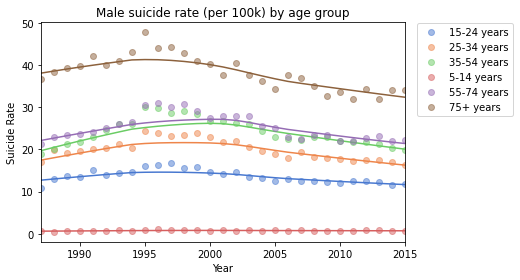

In [205]:
#cross tabulation of year and age by gender (male) with mean suicide rate as values
males = fullDF[fullDF['sex']=='male']

age_male = males['age']

yearxage_male = pd.crosstab( year, age_male, suicide_rate, aggfunc=np.mean)

yearxage_male.dropna(inplace=True)

# Male age groups suicide rate (per 100k)

plot_columns_lowess(yearxage_male, columns1, color_map2)
decorate(xlabel='Year',
         ylabel='Suicide Rate',
         title='Male suicide rate (per 100k) by age group',
         xlim=[1987, 2015])
anchor_legend(1.02, 1.02)

Plotting the time series of female suicide rates by age group, we see that it follows the trends observed in the suicide rates by age. However, women are much less likely to commit suicide them men by a factor of 1/2 or less.

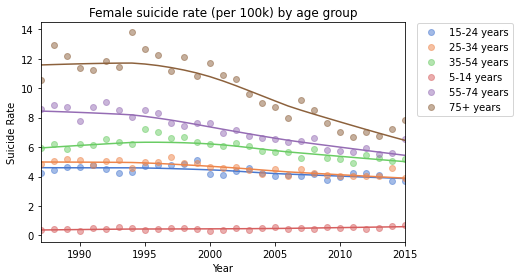

In [206]:
#cross tabulation of year and age by gender (female) with mean suicide rate as values
females = fullDF[fullDF['sex']=='female']

age_female = females['age']

yearxage_female = pd.crosstab( year, age_female, suicide_rate, aggfunc=np.mean)

yearxage_female.dropna(inplace=True)

# Male age groups suicide rate (per 100k)

plot_columns_lowess(yearxage_female, columns1, color_map2)
decorate(xlabel='Year',
         ylabel='Suicide Rate',
         title='Female suicide rate (per 100k) by age group',
         xlim=[1987, 2015])
anchor_legend(1.02, 1.02)

## Analysis using Regression

In this section, we will use regression (multiple and logistics regression) to explore the relationships of suicide rates with variables of interest. We do this because from the visualizations we saw earlier, we see that the data's trend overtime has been non-linear. We will first explore the relationship of suicide rates with age and gender. 


In [207]:
import statsmodels.formula.api as smf

Let's start by exploring the regression results individually of suicide rates compared with age first, then sex. We will then add them together to perform a logistics regression.

In [208]:
age_model = smf.ols('suicides_per_100k ~ C(age)', data=fullDF).fit()
age_model.params

Intercept                 8.947154
C(age)[T.25-34 years]     3.239731
C(age)[T.35-54 years]     6.000287
C(age)[T.5-14 years]     -8.327113
C(age)[T.55-74 years]     7.208425
C(age)[T.75+ years]      15.008255
dtype: float64

Given the regression slopes for each age group, we observe a steady increase in the slopes up until the age category 75+ where it doubles. 

We can interpret the regression slopes this way. Given an age category of our population, we can estimate the suicide rate of that age category to be the intercept (8.96 in our case) + the regression slope of that given age category.

And given our initial visualizations of the relationship between suicide rates and age, this adds up. 

Doing a linear regression for gender, we see that isolating our population that gender, the male population's suicide rate would be approximately 21 suicides per 100k men. Our earlier visualization agrees with this. 



In [209]:
sex_model = smf.ols('suicides_per_100k ~ C(sex)', data=fullDF).fit()
sex_model.params

Intercept          5.392866
C(sex)[T.male]    14.846462
dtype: float64

So now let's explore how much age and sex impact suicide rates in a population. 

In [210]:
age_sex_model = smf.ols('suicides_per_100k ~ C(sex) + C(age)', data=fullDF).fit()
age_sex_model.params

Intercept                 1.523923
C(sex)[T.male]           14.846462
C(age)[T.25-34 years]     3.239731
C(age)[T.35-54 years]     6.000287
C(age)[T.5-14 years]     -8.327113
C(age)[T.55-74 years]     7.208425
C(age)[T.75+ years]      15.008255
dtype: float64

What this tells us is that populations with a large proportion of old people and men will most likely have pretty high suicide rates. 

Let's isolate GDP per capita now and then see if we should add it to our multiple regression. 

In [211]:
gdp_capita_model = smf.ols('suicides_per_100k ~ gdp_per_capita', data=fullDF).fit()
gdp_capita_model.params

Intercept         12.785871
gdp_per_capita     0.000002
dtype: float64

Interestingly, GDP per capita, whether high or low does not influence suicide rates that much. It's impact appears to be minimal. Therefore, there is no reason to add it to our multiple regression.  